In [38]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import collections
import re
from matplotlib import colors as mcolors

import IPython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
def plot_all(datafile_num):
    
    def load_data(datafile_num):
        data_folder = '../output-explore-infl-logreg/'
        data_filenames = [#'explore-infl-logreg-data-hospital-prop-0.1-subsets-5-subset_seed-13-center-data-False.npz',
                         #'explore-infl-logreg-data-hospital-prop-0.1-subsets-5-subset_seed-13-center-data-False_hubert.npz',
                         #'explore-infl-logreg-data-hospital-prop-0.1-subsets-6-subset_seed-13-center-data-False.npz',
                         #'explore-infl-logreg-data-hospital-prop-0.1-subsets-30-subset_seed-13-center-data-False.npz',
                         'explore-infl-logreg-data-hospital-prop-0.1-subsets-10-subset_seed-0-center-data-False.npz',
                         'explore-infl-logreg-data-processed_imageNet-prop-0.09-subsets-10-subset_seed-0-center-data-False.npz']
        data_filename = data_filenames[datafile_num]
        global experiment_info
        experiment_info = re.match(r'explore-infl-logreg-data-(\w+)-prop-(\d+\.\d*)-subsets-(\w+)-subset_seed-(\w+)-center-data-False\.npz', data_filename)
        # experiment_info[1] is dataset_type
        # experiment_info[2] is proportion
        # experiment_info[3] is subset number
        # experiment_info[4] is subset_seed
        
        print(data_filename)
        f = np.load(os.path.join(data_folder, data_filename))
        f = collections.defaultdict(lambda: None, f)

        global initial_train_losses
        global initial_test_losses
        global initial_train_margins
        global initial_test_margins
        global grad_loss
        global test_points
        global fixed_test_pred_infl
        global fixed_test_pred_margin_infl
        global subset_tags
        global subset_indices
        global subset_train_losses
        global subset_test_losses
        global subset_train_margins
        global subset_test_margins
        global subset_self_influences
        global subset_self_pred_margin_influences
        
        initial_train_losses = f['initial_train_losses']
        initial_test_losses = f['initial_test_losses']
        initial_train_margins = f['initial_train_margins']
        initial_test_margins = f['initial_test_margins']
        grad_loss = f['grad_loss']
        test_points = f['test_points']
        fixed_test_pred_infl = f['fixed_test_pred_infl']
        fixed_test_pred_margin_infl = f['fixed_test_pred_margin_infl']
        subset_tags = f['subset_tags']
        subset_indices = f['subset_indices']
        subset_train_losses = f['subset_train_losses']
        subset_test_losses = f['subset_test_losses']
        subset_train_margins = f['subset_train_margins']
        subset_test_margins = f['subset_test_margins']
        subset_self_influences = f['subset_self_pred_infl']
        subset_self_pred_margin_influences = f['subset_self_pred_margin_infl']

        # old naming convention
        if subset_self_influences is None:
            subset_self_influences = f['subset_self_influences']
        if subset_self_pred_margin_influences is None:
            subset_self_pred_margin_influences = f['subset_self_margin_influences']

        for i, tag in enumerate(subset_tags):
            if re.search('pos_tail_test', tag):
                subset_tags[i] = 'pos_tail_test'
            elif re.search('neg_tail_test', tag):
                subset_tags[i] = 'neg_tail_test'
        unique_tags = np.unique(subset_tags)
        unique_subset_colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k', 'coral', 'olive', 'dodgerblue', 'pink', 'khaki', 'peru', 'indigo', 'orange', 'springgreen', 'rebeccapurple']
        assert len(unique_subset_colors) >= len(unique_tags)
        tag_to_color = dict(zip(unique_tags, range(len(unique_tags))))
        global subset_colors
        subset_colors = [unique_subset_colors[tag_to_color[tag]] for tag in subset_tags]

    # Plot self-influence actual vs predicted
    def plot_self_infl_data(mode='loss'):
        assert mode in ['loss', 'margin']
        plt.figure(figsize=(4,4))
        W = 0
        labels = set()
        if mode == 'loss':
            init = initial_train_losses
            subset_train = subset_train_losses
            subset_self_infl = subset_self_influences
        elif mode == 'margin':
            init = initial_train_margins
            subset_train = subset_train_margins
            subset_self_infl = subset_self_pred_margin_influences
        assert init is not None and subset_train is not None and subset_self_infl is not None

        for subset_num, indices in enumerate(subset_indices):
            subset_initial_losses = np.sum(init[indices])
            subset_retrained_losses = np.sum(subset_train[subset_num][indices])
            subset_actl_infl = subset_retrained_losses - subset_initial_losses
            subset_pred_infl = subset_self_infl[subset_num]
            subset_actl_infl /= len(indices)
            subset_pred_infl /= len(indices)
            W = max(W, np.max(np.abs(subset_actl_infl)), np.max(np.abs(subset_pred_infl)))
            if subset_tags[subset_num] not in labels:
                label = subset_tags[subset_num]
                labels.add(label)
            else:
                label = None
            plt.scatter(subset_actl_infl, subset_pred_infl, color=subset_colors[subset_num], label=label, alpha=0.2)

        if mode == 'loss':
            plt.plot([-W/20, W], [-W/20, W],color='grey',alpha=0.3)
        elif mode == 'margin':
            plt.plot([-W, W/20], [-W, W/20],color='grey',alpha=0.3)
        plt.title('Self-influence: {}, seed {}, {} subset'.format(experiment_info.group(1), experiment_info.group(4), experiment_info.group(3)))
        plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), ncol=1)
        plt.xlabel('Actual average of self-{} for subset'.format(mode))
        plt.ylabel('Predicted average of self-{} for subset'.format(mode))
        plt.savefig('../output-explore-infl-logreg/plots/{}_seed_{}_num_{}_self_{}.png'.format(experiment_info.group(1), experiment_info.group(4), experiment_info.group(3), mode), bbox_inches="tight")
        plt.show()

    # Plot fixed test point actual vs predicted
    def plot_test_pt_data(mode='loss'):
        assert mode in ['loss', 'margin']
        fig, axs = plt.subplots(len(test_points), 1, figsize=(4, 4 * len(test_points)), squeeze=False)

        for i, test_idx in enumerate(test_points):
            #if i > 0: break
            W = 0
            if mode == 'loss':
                init = initial_test_losses
                subset_test = subset_test_losses
                fixed_test_pred = fixed_test_pred_infl
            elif mode == 'margin':
                init = initial_test_margins
                subset_test = subset_test_margins
                fixed_test_pred = fixed_test_pred_margin_infl
            assert init is not None and subset_test is not None and fixed_test_pred is not None

            subset_initial_losses = np.array(init[test_idx])
            labels = set()
            for subset_num, indices in enumerate(subset_indices):
                subset_retrained_losses = np.array(subset_test[subset_num][test_idx])
                subset_actl_infl = subset_retrained_losses - subset_initial_losses
                subset_pred_infl = np.sum(fixed_test_pred[i][indices])
                if subset_tags[subset_num] not in labels:
                    label = subset_tags[subset_num]
                    labels.add(label)
                else:
                    label = None
                axs[i][0].scatter(subset_actl_infl, subset_pred_infl, color=subset_colors[subset_num], label=label, alpha=0.2)
                W = max(W, np.max(np.abs(subset_actl_infl)), np.max(np.abs(subset_pred_infl)))

            axs[i][0].plot([-W, W], [-W, W],color='grey',alpha=0.3)
            axs[i][0].set_title('Test_idx: {}; {}, seed {}, {} subset'.format(test_idx, experiment_info.group(1), experiment_info.group(4), experiment_info.group(3)))
            axs[i][0].legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), ncol=1)
            axs[i][0].set_xlabel('Actual influence on test pt {}'.format(mode))
            axs[i][0].set_ylabel('Predicted influence on test pt {}'.format(mode))
        fig.subplots_adjust(hspace=0.4)
        plt.savefig('../output-explore-infl-logreg/plots/{}_seed_{}_num_{}_test_{}.png'.format(experiment_info.group(1), experiment_info.group(4), experiment_info.group(3), mode), bbox_inches="tight")
        plt.show()

    load_data(datafile_num)
    plot_self_infl_data()
    if experiment_info.group(1) not in ['spam', 'processed_imageNet']:
        plot_self_infl_data('margin')
    plot_test_pt_data()
    if experiment_info.group(1) not in ['spam', 'processed_imageNet']:
        plot_test_pt_data('margin')

explore-infl-logreg-data-hospital-prop-0.1-subsets-10-subset_seed-0-center-data-False.npz


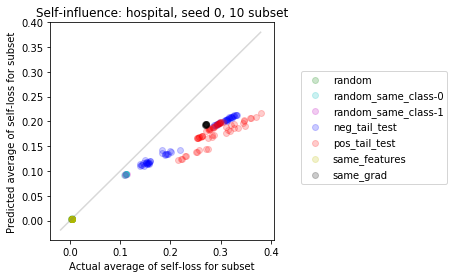

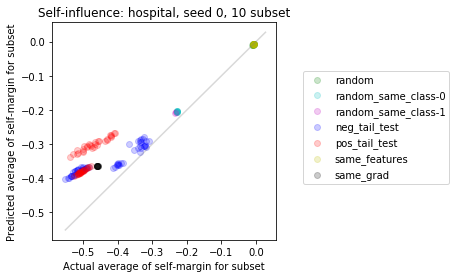

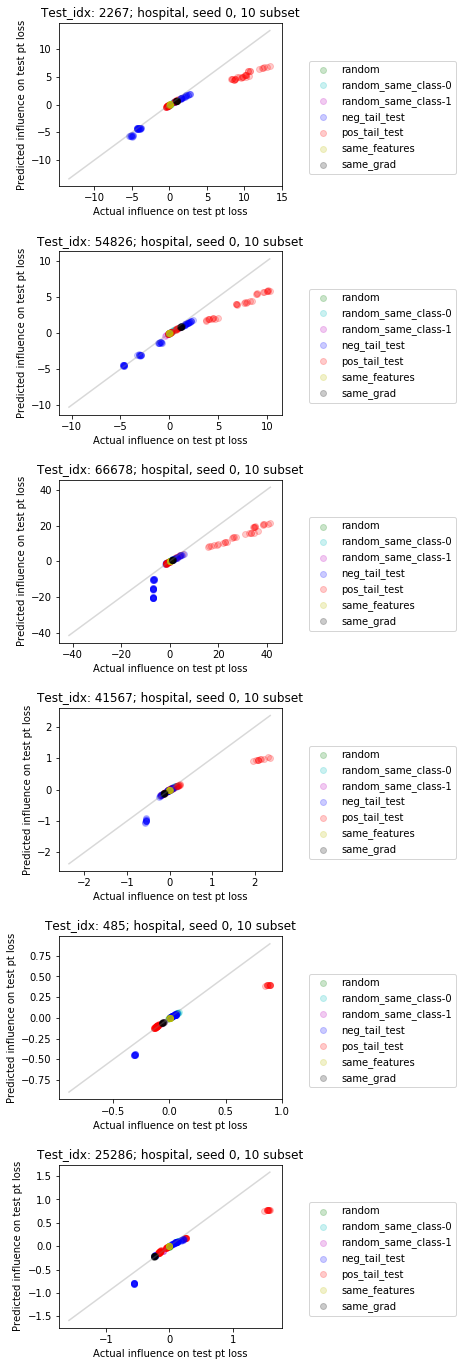

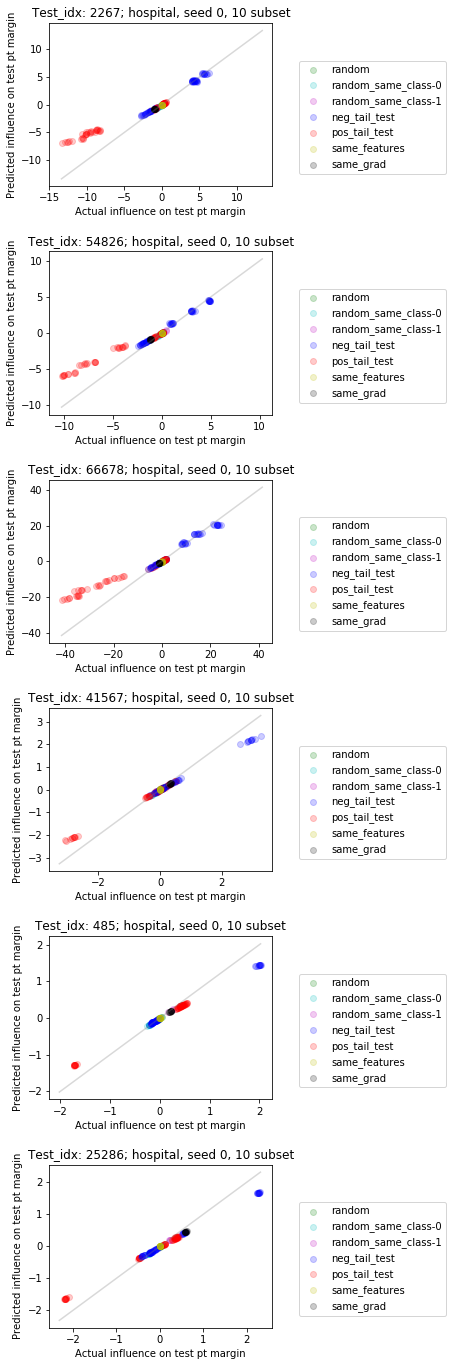

In [67]:
plot_all(0)

explore-infl-logreg-data-processed_imageNet-prop-0.09-subsets-10-subset_seed-0-center-data-False.npz


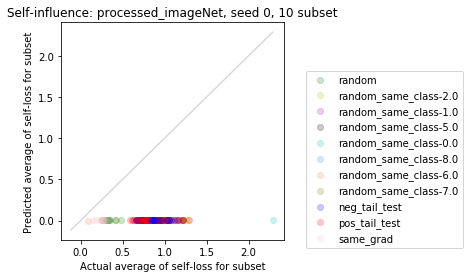

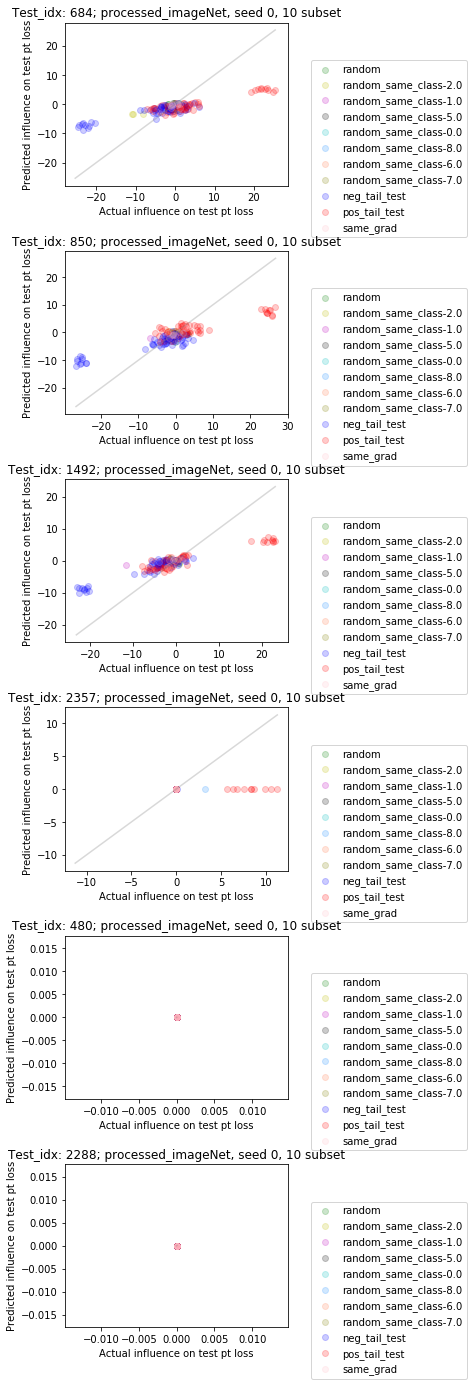

In [68]:
plot_all(1)